In [486]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
import missingno as msno
import geopandas as gpd
from shapely import wkt
import numpy as np
from shapely.geometry import MultiPoint
from scipy.spatial import QhullError
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib as mpl


/tmp/ipykernel_11162/2446858160.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  cartofriches = pd.read_csv("data/cartofriches.csv", sep=";")


<Axes: >

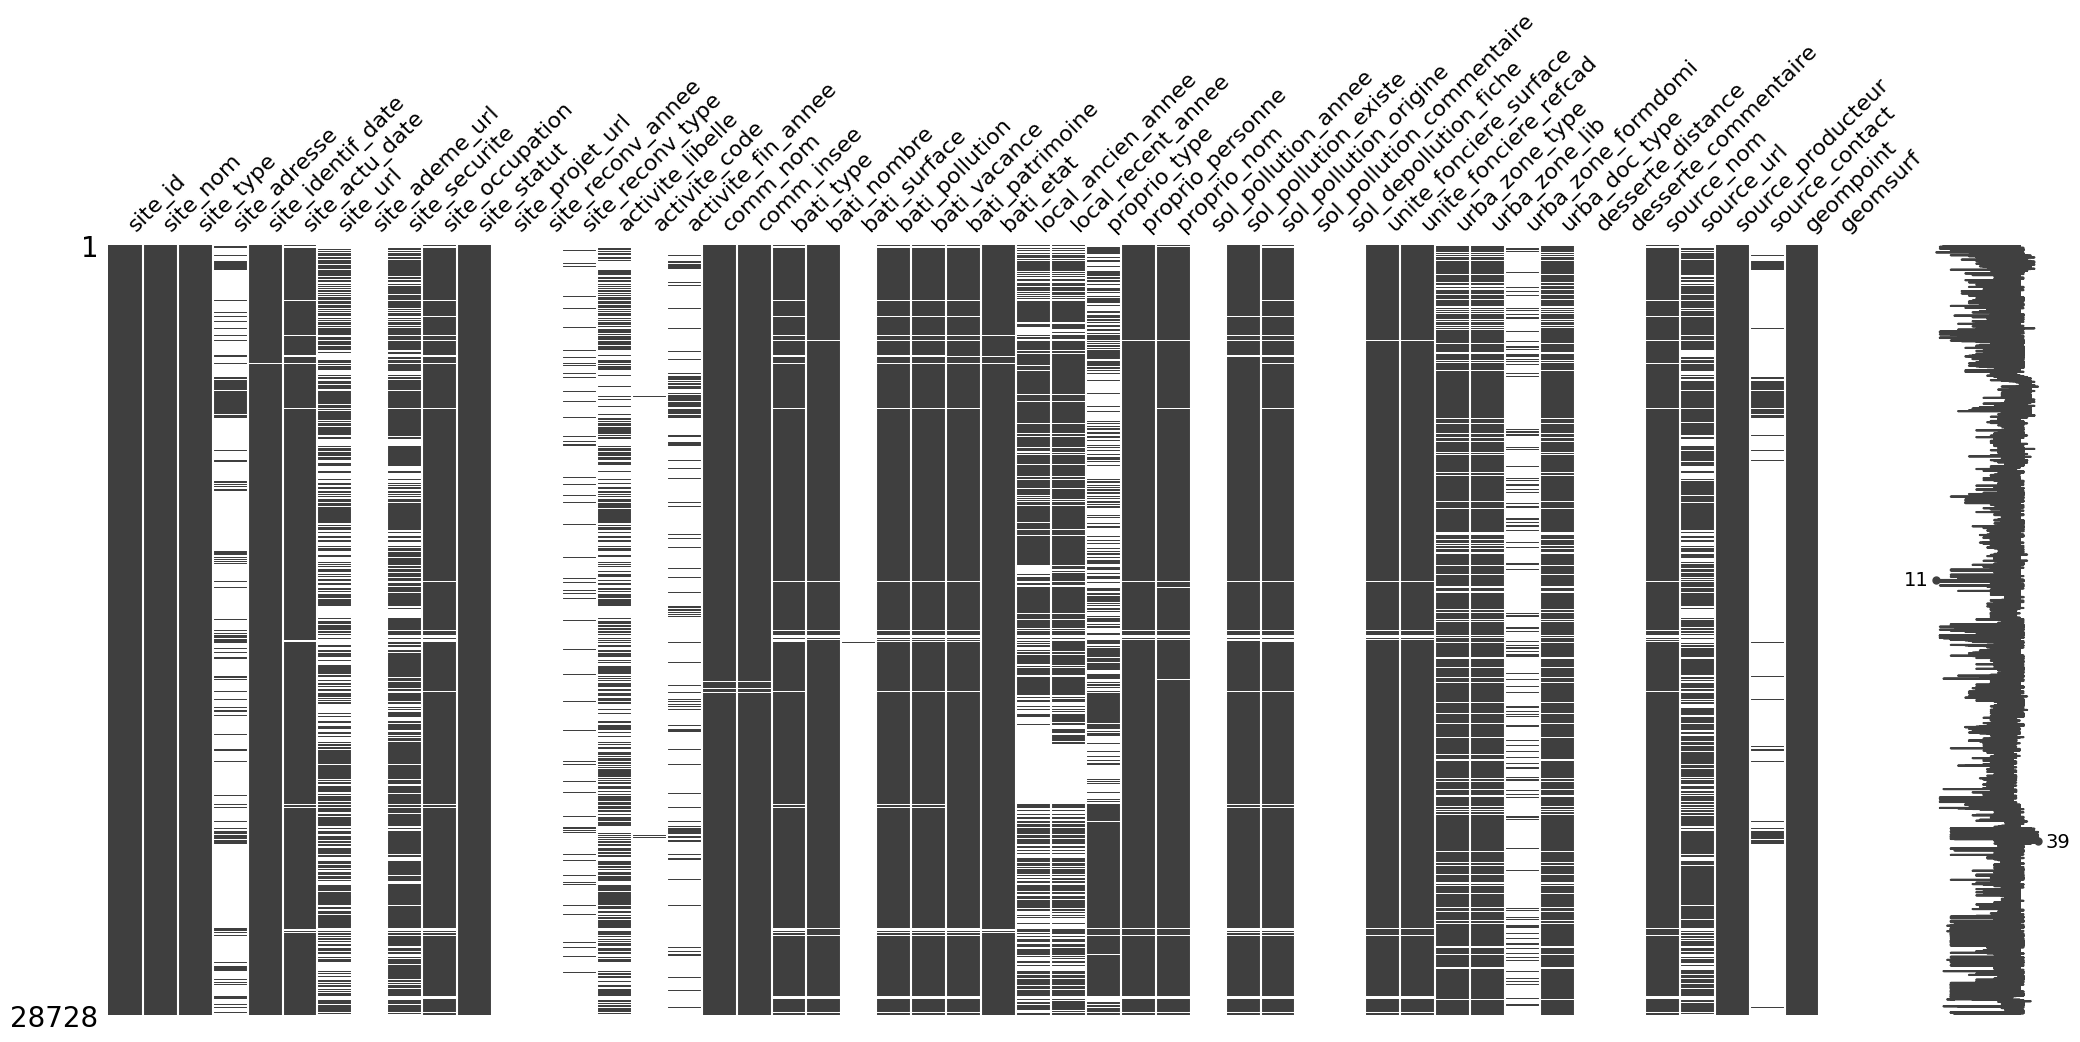

In [487]:
cartofriches = pd.read_csv("data/cartofriches.csv", sep=";")
msno.matrix(cartofriches)

In [488]:
regions = gpd.read_file("data/regions.geojson")
idf = regions[regions["nom"] == "Île-de-France"]
hdf = regions[regions["nom"] == "Hauts-de-France"]
cartofriches["geompoint"] = cartofriches["geompoint"].apply(wkt.loads)
ihdf = pd.concat([idf, hdf])

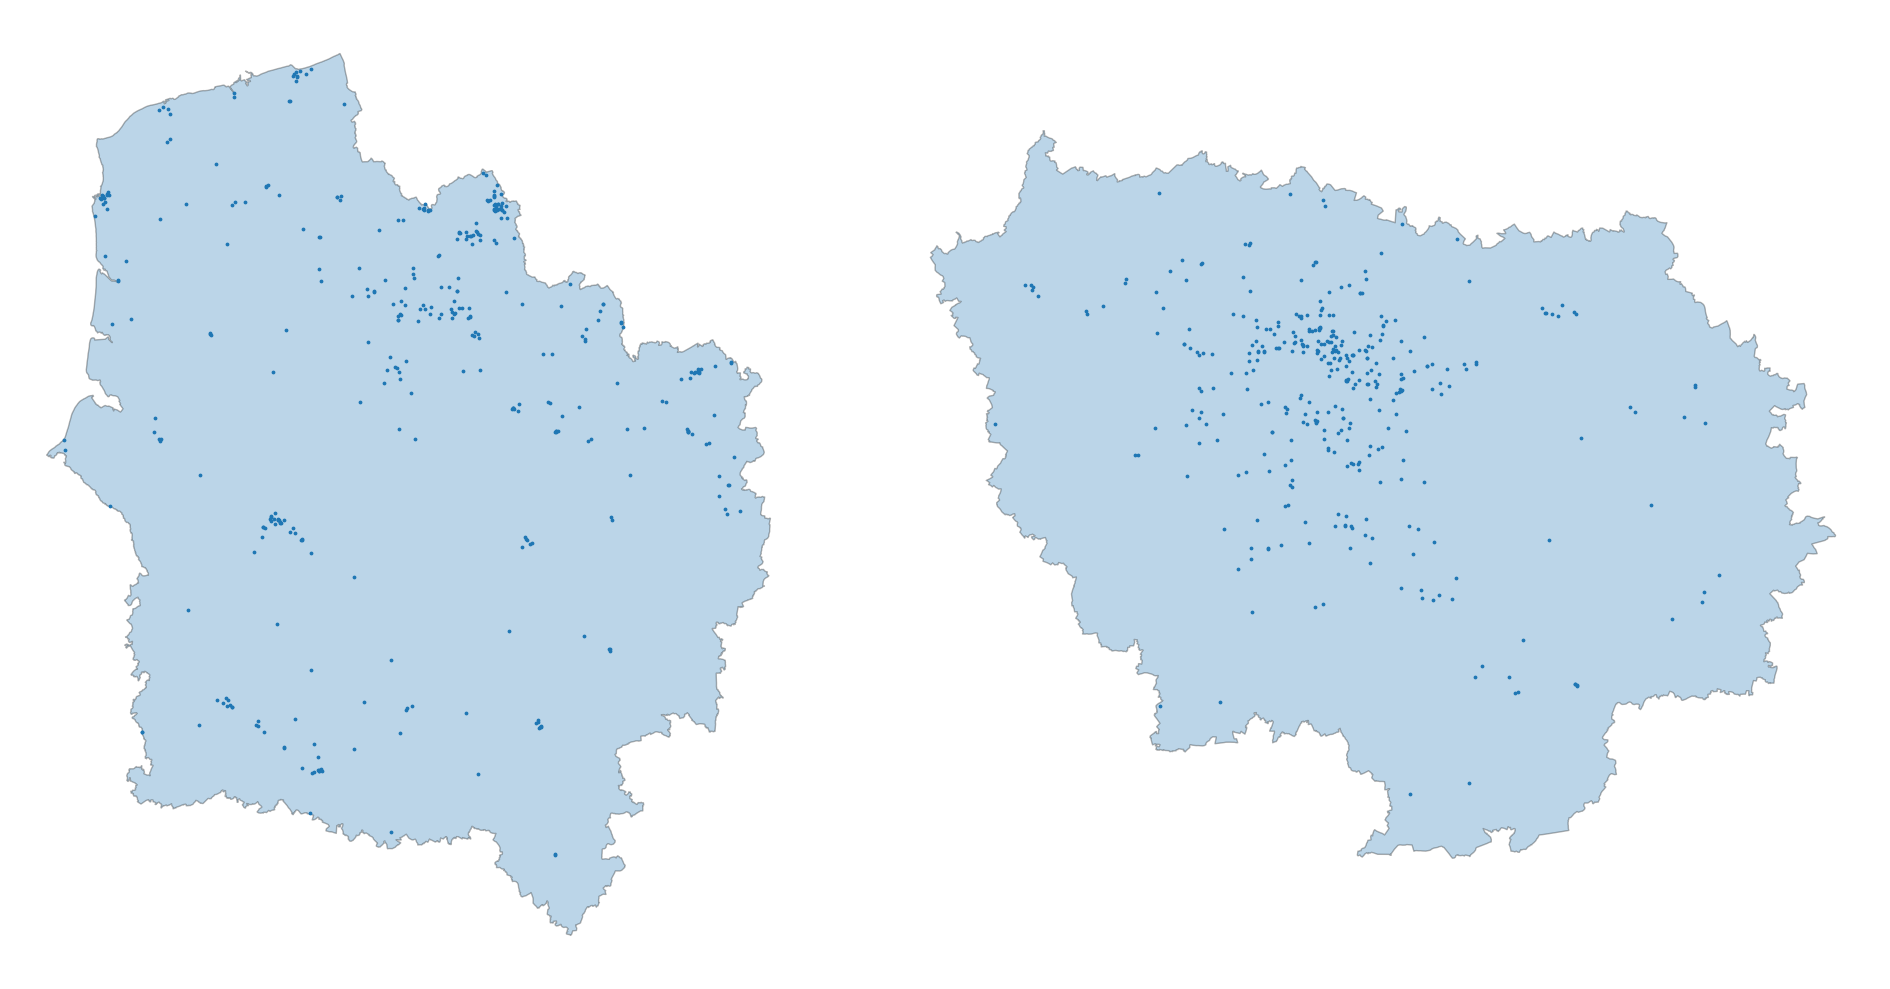

In [489]:
friches = gpd.GeoDataFrame(
    cartofriches[cartofriches["site_statut"].str.contains(r"reconvertie|avec")],
    geometry="geompoint",
    crs="EPSG:4326"
)

friches_hdf = friches[friches.within(hdf.union_all())]
friches_idf = friches[friches.within(idf.union_all())]
friches_ihdf = friches[friches.within(ihdf.union_all())]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
hdf.plot(ax=ax, alpha=.3, edgecolor="black")
friches_hdf.plot(ax=ax, markersize=3)
ax.axis("off")

ax = axes[1]
idf.plot(ax=ax, alpha=.3, edgecolor="black")
friches_idf.plot(ax=ax, markersize=3)
ax.axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_11162/37060094.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  friches_clusters = friches[(friches["cluster"] != -1) & (friches.within(ihdf.unary_union))]


<Axes: >

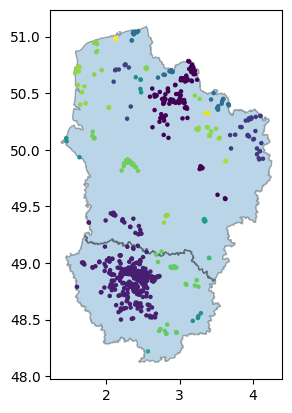

In [490]:
coords = np.vstack((friches.geometry.x, friches.geometry.y)).T
db = DBSCAN(eps=0.12, min_samples=2).fit(coords)
friches["cluster"] = db.labels_
friches_clusters = friches[(friches["cluster"] != -1) & (friches.within(ihdf.unary_union))]
ax = ihdf.plot(alpha=.3, edgecolor="black")
friches_clusters.plot(ax=ax, column="cluster", markersize=5)

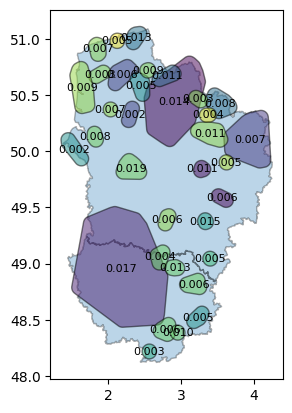

In [491]:
friches_m = friches_clusters.to_crs(3857)

polygons_m = (
    friches_m
    .dissolve(by="cluster")
    .convex_hull
    .reset_index()
)

polygons_m = polygons_m.rename(columns={0: "geometry"})
polygons_m = gpd.GeoDataFrame(polygons_m, geometry="geometry", crs=3857)

buffer_distance = 11000
polygons_m["geometry"] = polygons_m.geometry.buffer(buffer_distance)

polygons_gdf = polygons_m.to_crs(4326)


gdf_points_m = friches_clusters.to_crs(3857)

join = gpd.sjoin(
    gdf_points_m,
    polygons_m,
    how="left",
    predicate="within"
)

counts = (
    join.groupby("index_right")
        .size()
        .reset_index(name="count")
)

polygons_m["area_m2"] = polygons_m.area
polygons_m = polygons_m.reset_index()

polygons_m = polygons_m.merge(
    counts,
    left_on="index",
    right_on="index_right",
    how="left"
)

polygons_m["density_m2"] = polygons_m["count"] / polygons_m["area_m2"]
polygons_m["density_km2"] = polygons_m["density_m2"] * 1e6


centroids_m = polygons_m.copy()
centroids_m["geometry"] = centroids_m.centroid

centroids = centroids_m.to_crs(4326)[["density_km2", "geometry"]]


polygons = polygons_m.to_crs(4326)


ax = ihdf.plot(alpha=.3, edgecolor="black")
polygons.plot(ax=ax, column="cluster", alpha=0.5, edgecolor="black")

for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, centroids["density_km2"]):
    ax.text(x, y, f"{label:.3f}", fontsize=8, ha="center", va="center")

In [492]:
csp_2021 = pd.read_csv("data/CSP2021.csv", low_memory=False)
csp_1968 = pd.read_csv("data/CSP1968.csv", low_memory=False)

<Axes: >

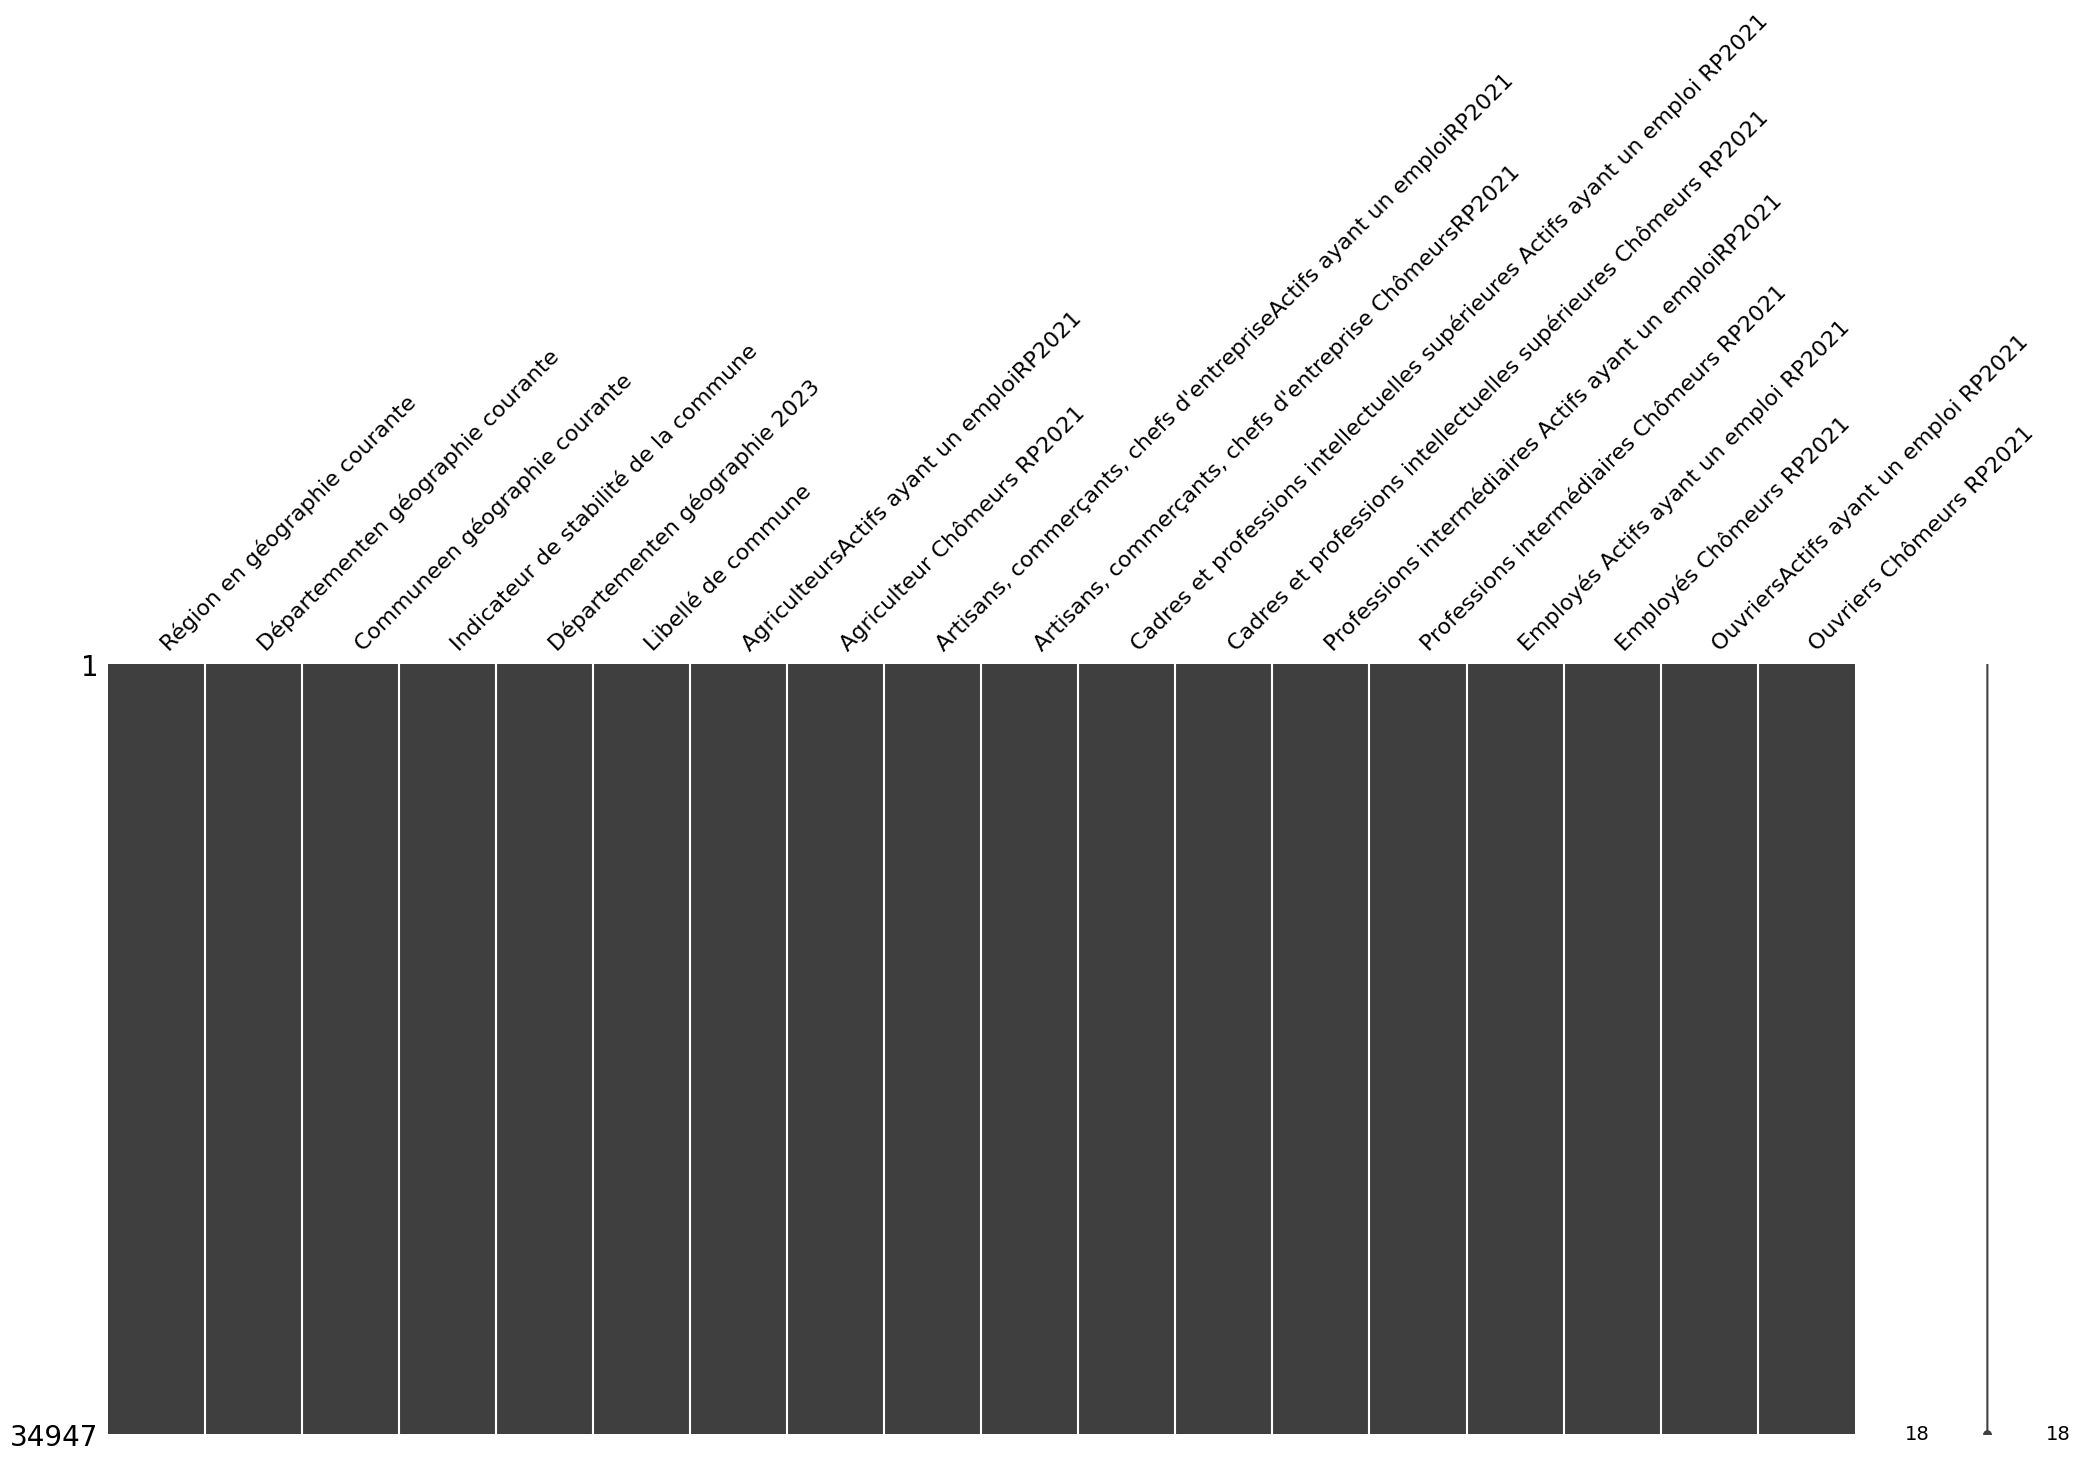

In [493]:
csp_2021.dropna(axis=0, inplace=True)
csp_1968.dropna(axis=0, inplace=True)
msno.matrix(csp_2021)

In [494]:
csp_2021.iloc[:, 6:] = csp_2021.iloc[:, 6:].apply(lambda x: pd.to_numeric(x.str.replace('\u202f','', regex=False) if x.dtype == 'object' else x, errors='coerce'))
csp_2021 = csp_2021[csp_2021["Région en géographie courante"].isin([11, 32])]
csp_2021["Total"] = csp_2021.iloc[:, 6:len(csp_2021.columns)].sum(axis=1)
csp_2021 = csp_2021[csp_2021["Total"] > 0]
csp_2021["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] = csp_2021["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"] / csp_2021["Total"] * 100
csp_2021 = csp_2021[["Libellé de commune", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021", "Total"]]

csp_1968.iloc[:, 6:] = csp_1968.iloc[:, 6:].apply(lambda x: pd.to_numeric(x.str.replace('\u202f','', regex=False) if x.dtype == 'object' else x, errors='coerce'))
csp_1968 = csp_1968[csp_1968["Région en géographie courante"].isin([11, 32])]
csp_1968["Total"] = csp_1968.iloc[:, 6:len(csp_1968.columns)].sum(axis=1)
csp_1968 = csp_2021[csp_1968["Total"] > 0]
csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] = csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"] / csp_1968["Total"] * 100
csp_1968 = csp_1968[["Libellé de commune", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021", "Total"]]

/tmp/ipykernel_11162/3148476668.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  csp_1968 = csp_2021[csp_1968["Total"] > 0]
/tmp/ipykernel_11162/3148476668.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] = csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"] / csp_1968["Total"] * 100


In [495]:
communes = gpd.read_file("data/communes.geojson")
communes = communes.iloc[:,1:]
communes = communes.to_crs(epsg=4326)
communes = communes[communes.geometry.within(ihdf.unary_union)]
communes = communes.reset_index()  

communes_2021 = communes.merge(csp_2021, left_on="nom", right_on="Libellé de commune", how="inner")
communes_1968 = communes.merge(csp_1968, left_on="nom", right_on="Libellé de commune", how="inner")

if "level_0" in communes.columns:
    communes = communes.drop(columns=["level_0"])

communes = communes.reset_index(drop=True)

if 0 in polygons.columns:
    polygons = polygons.rename(columns={0: "geometry"})

for col in ["index_right"]:
    if col in polygons.columns:
        polygons = polygons.drop(columns=[col])

polygons = polygons.reset_index(drop=True)

polygons = polygons.set_geometry("geometry")


join = gpd.sjoin(
    communes,
    polygons[["geometry", "density_km2"]],
    how="left",
    predicate="intersects"
)


regions_density = (
    join.groupby("index")["density_km2"]
        .sum()
        .reset_index()
)

communes = communes.merge(
    regions_density,
    on="index",
    how="left"
)


/tmp/ipykernel_11162/3873407510.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  communes = communes[communes.geometry.within(ihdf.unary_union)]


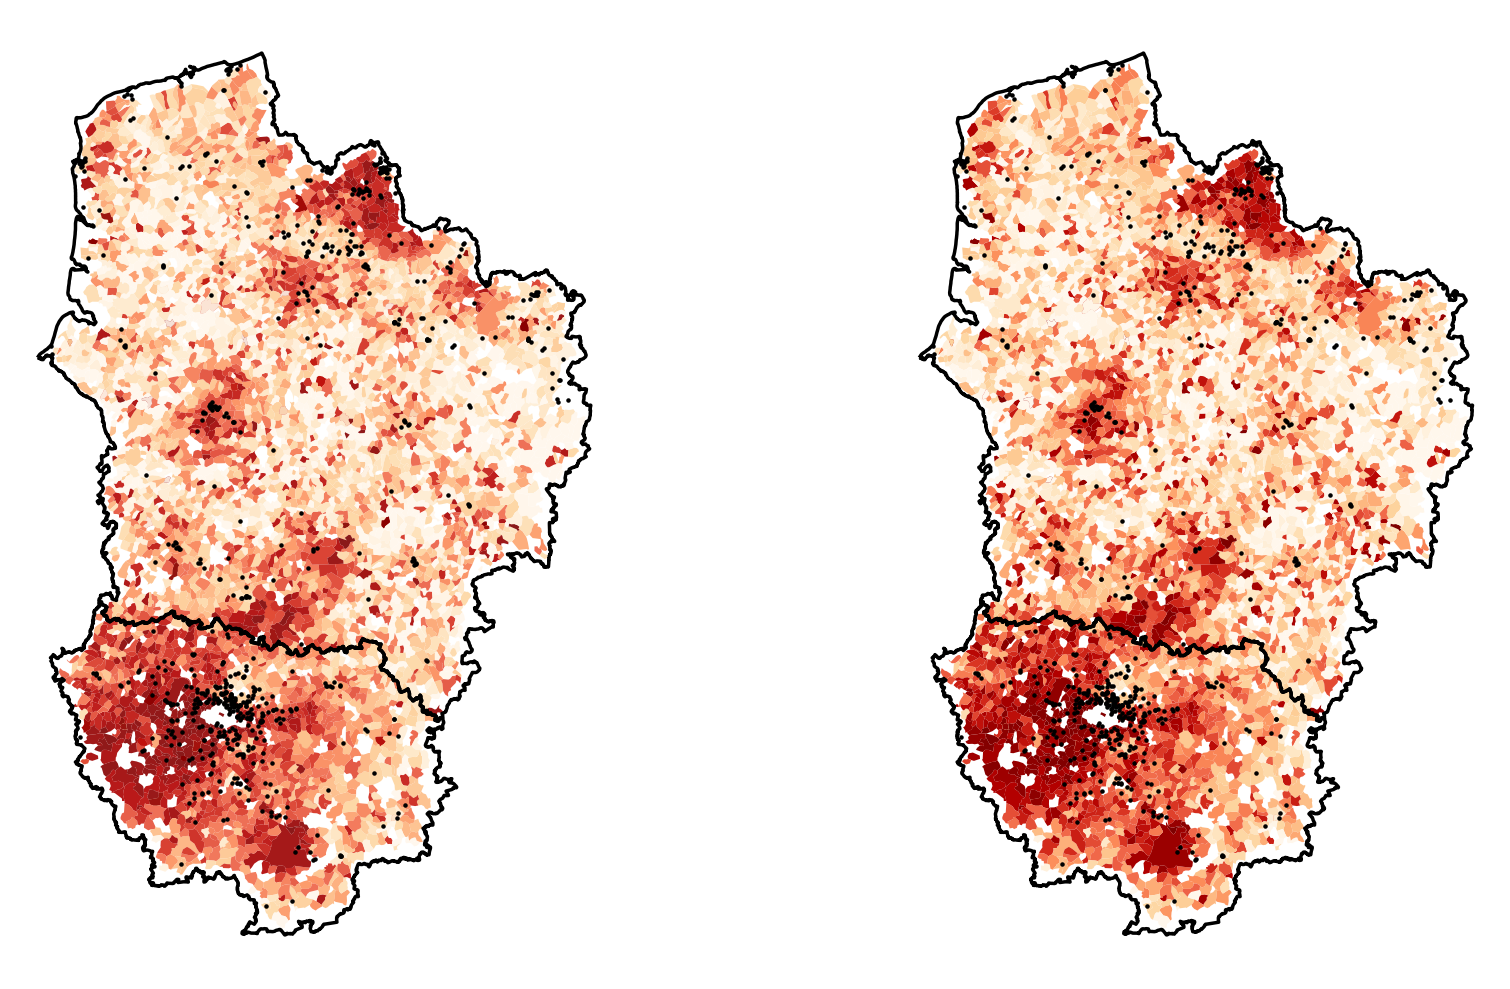

In [496]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
communes_2021.plot(
    ax=ax,
    alpha=.9,
    linewidth=0,
    column="Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%",
    cmap="OrRd"
)
ihdf.boundary.plot(ax=ax, color="black", linewidth=2.5)
friches_ihdf.plot(ax=ax, markersize=5, color="black")
ax.axis('off')

ax = axes[1]
communes_1968.plot(
    ax=ax,
    alpha=1,
    linewidth=0,
    column="Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%",
    cmap="OrRd"
)
ihdf.boundary.plot(ax=ax, color="black", linewidth=2.5)
friches_ihdf.plot(ax=ax, markersize=5, color="black")
ax.axis('off')

plt.tight_layout()
plt.show()

In [497]:
diff = pd.DataFrame()
diff["Libellé de commune"] = communes_2021["Libellé de commune"]
diff["%Cadres"] = communes_2021["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] - communes_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"]
diff["Pop"] = communes_2021["Total"] - communes_1968["Total"]

diff = communes.merge(diff, left_on="nom", right_on="Libellé de commune", how="inner")

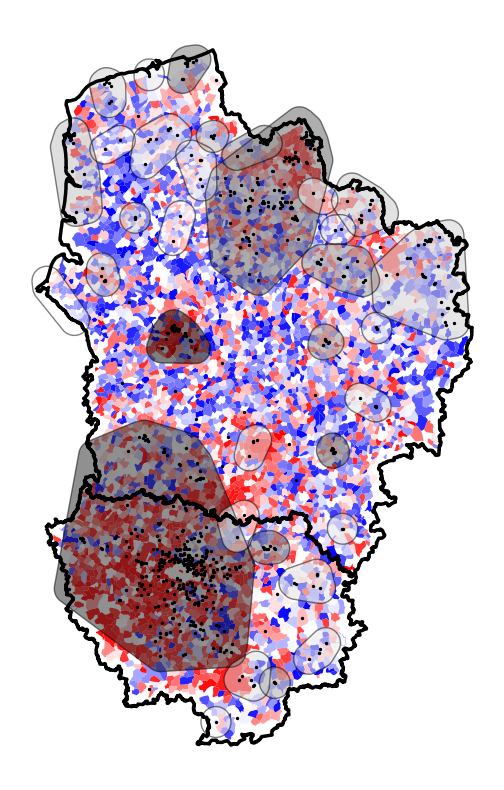

In [498]:
ax = diff.plot(alpha=1,figsize=(12, 10), linewidth=0, column="%Cadres", cmap="bwr")
ihdf.boundary.plot(ax=ax, color="black", linewidth=2.5)
polygons.plot(ax=ax, alpha=.5, cmap="Greys", linewidth=1, column="density_km2")
polygons.boundary.plot(ax=ax, alpha=.5, color='black', linewidth=1)
friches_ihdf.plot(ax=ax, markersize=2, color="black")
ax.axis('off')
plt.show()

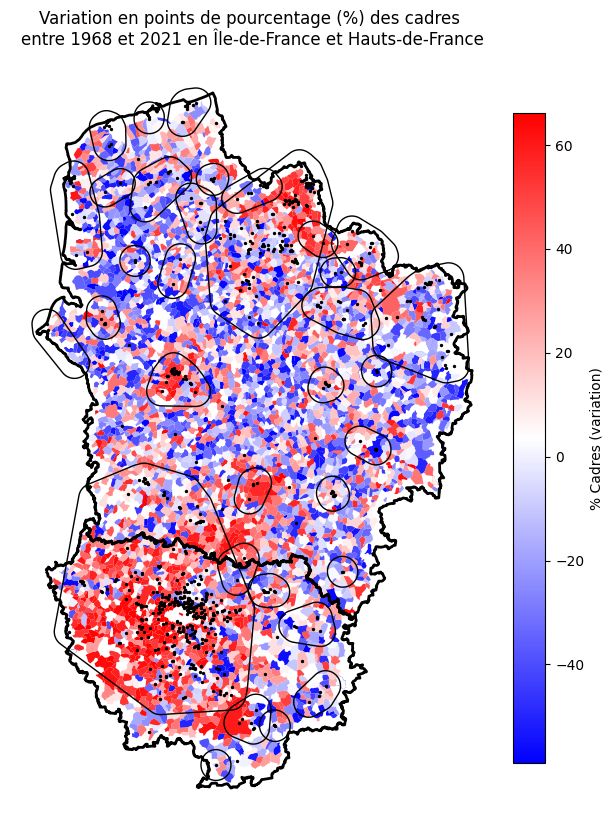

In [499]:
ax = diff.plot(alpha=1,figsize=(12, 10), linewidth=0, column="%Cadres", cmap="bwr", legend=False)
ihdf.boundary.plot(ax=ax, color="black", linewidth=2)
polygons.boundary.plot(ax=ax, color='black', linewidth=1)
friches_ihdf.plot(ax=ax, markersize=2, color="black", legend=True)

sm = mpl.cm.ScalarMappable(
    cmap="bwr",
    norm=mpl.colors.Normalize(
        vmin=diff["%Cadres"].min(),
        vmax=diff["%Cadres"].max()
    )
)
sm._A = []  # hack pour compatibilité
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("% Cadres (variation)")

ax.set_title("Variation en points de pourcentage (%) des cadres \nentre 1968 et 2021 en Île-de-France et Hauts-de-France")
ax.axis('off')
plt.show()

<Axes: xlabel='%Cadres', ylabel='Count'>

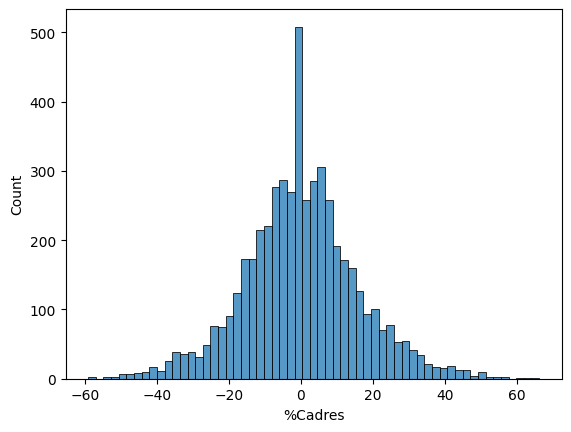

In [500]:
sns.histplot(diff, x="%Cadres")

In [501]:
diff['%Cadres'] = pd.to_numeric(diff['%Cadres'], errors='coerce')
diff['density_km2'] = pd.to_numeric(diff['density_km2'], errors='coerce')
diff = diff[['%Cadres','density_km2']].dropna()

pearsonr(clean['%Cadres'], clean['density_km2'])

PearsonRResult(statistic=np.float64(0.2700463271965404), pvalue=np.float64(4.508616533727956e-87))

<Axes: xlabel='density_km2', ylabel='%Cadres'>

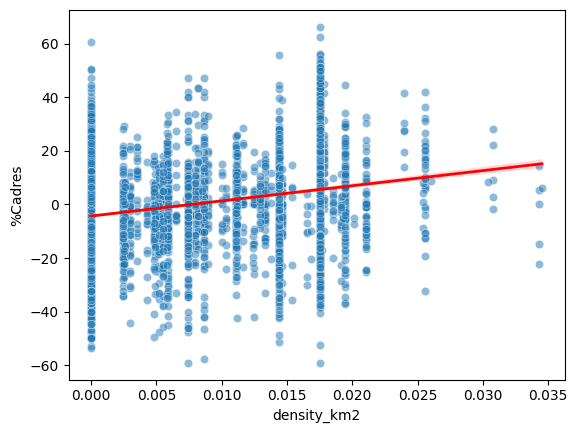

In [502]:
sns.scatterplot(data=diff, x="density_km2", y="%Cadres", alpha=0.5)
sns.regplot(data=diff, x="density_km2", y="%Cadres", color="red", scatter=False, line_kws={"linewidth":2})